In [27]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
from spotipy.oauth2 import SpotifyOAuth
import json
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
import sklearn
from numpy.linalg import norm

# Communicating with Spotify API 

In [28]:
#communicating with the Spotify API using my Spotify Developer account
CLIENT_ID = '2f4ee4b4bf804aafa1472394ff530327'
CLIENT_SECRET = '2c1d747ba23b4d48b2ea30b479edad13'

In [29]:

#we need an access token in order to access endpoints of the Spotify API
AUTH_URL = 'https://accounts.spotify.com/api/token'


#'playlist-modify-private user-library-read user-follow-read user-top-read playlist-modify-private'
# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'scope': 'playlist-modify-private playlist-read-private',
})

# convert the response to JSON
auth_response_data = auth_response.json()


# save the access token
access_token = auth_response_data['access_token']

# used for authenticating all API calls
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

#Authentication
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [30]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'
#https://api.spotify.com/v1/users/{user_id}/playlists

In [31]:
user_id = 'maerikhkb216y67i4c4ab66uy'
scope = 'playlist-modify-public'
redirect_uri = 'http://127.0.01:8080/'

#token = util.prompt_for_user_token(user_id, scope, CLIENT_ID, CLIENT_SECRET, redirect_uri)

token = SpotifyOAuth(username=user_id,
                     client_id=CLIENT_ID, 
                     client_secret=CLIENT_SECRET,
                     scope=scope,
                     redirect_uri = 'http://127.0.01:8080/')

sp = spotipy.Spotify(auth_manager = token)

### Function to get audio features from each track

In [8]:
# loop through track URIs and pull audio features using the API,
# store all these in a dictionary
def get_audio_features(track_uris):
    
    # create blank dictionary to store audio features    
    feature_dict = {}
    for t_uri in track_uris:

        feature_dict[t_uri] = {'acousticness': 0,
                               'popularity': 0,
                               'danceability': 0,
                               'energy': 0,
                               'liveness': 0,
                               'loudness': 0,
                               'speechiness': 0,
                               'instrumentalness': 0,
                               'tempo': 0,
                               'valence':0}

        r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
        r = r.json()
        feature_dict[t_uri]['popularity'] = r['popularity']

        s = requests.get(BASE_URL + 'audio-features/' + t_uri, headers=headers)
        s = s.json()

        feature_dict[t_uri]['acousticness'] = s['acousticness']
        feature_dict[t_uri]['danceability'] = s['danceability']
        feature_dict[t_uri]['energy'] = s['energy']
        feature_dict[t_uri]['liveness'] = s['liveness']
        feature_dict[t_uri]['loudness'] = s['loudness']
        feature_dict[t_uri]['speechiness'] = s['speechiness']
        feature_dict[t_uri]['instrumentalness'] = s['instrumentalness']
        feature_dict[t_uri]['tempo'] = s['tempo']
        feature_dict[t_uri]['valence'] = s['valence']
        
    return feature_dict

In [9]:
# convert dictionary into dataframe with track_uri as the first column
def dictionary_to_df(feature_dict):
    df_features = pd.DataFrame.from_dict(feature_dict, orient='index')
    df_features.insert(0, 'track_uri', df_features.index)
    df_features.reset_index(inplace=True, drop=True)
    
    return df_features
    

# Getting the data from my Spotify account

### Requested Listening History

Initally, I requested my listening history from Spotify

In [10]:
#getting the data from my library (liked songs in Spotify account)
df_library = pd.read_json('YourLibrary.json')
# add column with track URI stripped of 'spotify:track:'
new = df_library["uri"].str.split(":", expand = True)
df_library['track_uri'] = new[2]

df_library

,artist,album,track,uri,track_uri
0,George Ezra,2010s Hits,Budapest,spotify:track:2pgmVSAfyZn54DeSgLUFoj,2pgmVSAfyZn54DeSgLUFoj
1,Billy Bragg,Mermaid Avenue,California Stars,spotify:track:38paDDziQ57k1f4VfKTeGk,38paDDziQ57k1f4VfKTeGk
2,David Marston,Under the Covers,Feel Your Soul,spotify:track:2CXjrph4GOOERwlmak9CyE,2CXjrph4GOOERwlmak9CyE
3,ZHU,GENERATIONWHY,Good Life,spotify:track:6MWYSp8nWt4IZiRMCDPHXT,6MWYSp8nWt4IZiRMCDPHXT
4,The Weeknd,Trilogy,Rolling Stone,spotify:track:29fTi7Tdh9CiU8HuVDaqVY,29fTi7Tdh9CiU8HuVDaqVY
...,...,...,...,...,...
154,Red Hot Chili Peppers,The Getaway,Dark Necessities,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,2oaK4JLVnmRGIO9ytBE1bt
155,Frank Ocean,Blonde,Pink + White,spotify:track:3xKsf9qdS1CyvXSMEid6g8,3xKsf9qdS1CyvXSMEid6g8
156,The Weeknd,Blinding Lights,Blinding Lights,spotify:track:0sf12qNH5qcw8qpgymFOqD,0sf12qNH5qcw8qpgymFOqD
157,Flight Facilities,Down To Earth,Two Bodies,spotify:track:3WqifovLWUQICYOAad0aNP,3WqifovLWUQICYOAad0aNP


### Converting Listening History to a dataframe with extracted audio features for each track

In [11]:
# convert track_uri column to an iterable list
track_uris = df_library['track_uri'].to_list()

feature_dict = get_audio_features(track_uris)



In [12]:
df_features_library = dictionary_to_df(feature_dict)

In [13]:
df_features_library

,track_uri,acousticness,popularity,danceability,energy,liveness,loudness,speechiness,instrumentalness,tempo,valence
0,2pgmVSAfyZn54DeSgLUFoj,0.08500,25,0.714,0.430,0.1050,-9.345,0.0286,0.000000,127.790,0.400
1,38paDDziQ57k1f4VfKTeGk,0.42200,60,0.622,0.736,0.0829,-9.229,0.0292,0.000012,110.240,0.723
2,2CXjrph4GOOERwlmak9CyE,0.00362,45,0.842,0.708,0.0710,-8.610,0.0356,0.719000,127.012,0.781
3,6MWYSp8nWt4IZiRMCDPHXT,0.04530,59,0.734,0.758,0.6530,-6.288,0.0904,0.171000,116.019,0.214
4,29fTi7Tdh9CiU8HuVDaqVY,0.40500,54,0.693,0.323,0.1490,-11.970,0.0306,0.000022,129.964,0.669
...,...,...,...,...,...,...,...,...,...,...,...
154,2oaK4JLVnmRGIO9ytBE1bt,0.07220,73,0.700,0.742,0.1100,-6.777,0.0716,0.019900,91.959,0.197
155,3xKsf9qdS1CyvXSMEid6g8,0.66700,85,0.545,0.545,0.4170,-7.362,0.1070,0.000055,159.940,0.549
156,0sf12qNH5qcw8qpgymFOqD,0.00147,18,0.513,0.796,0.0938,-4.075,0.0629,0.000209,171.017,0.345
157,3WqifovLWUQICYOAad0aNP,0.48300,1,0.778,0.656,0.0825,-7.743,0.0867,0.818000,119.006,0.428


### Using Spotify API to extract songs from one of my favorite playlists called Mood 11

In [14]:
#on the safe side I have created a copy of this playlist for the purposes of this project 

playlist_link = "https://open.spotify.com/playlist/65oerHaWxRzc5WOFe3ZKof?si=25acdc81ebf64bf8"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

#strip the part spotify:track:uri and take only the uri section
track_uris_stripped = [i.split(':')[2] for i in track_uris]

In [15]:
feature_dict_playlist = get_audio_features(track_uris_stripped)
df_features_playlist = dictionary_to_df(feature_dict_playlist)
df_features_playlist


,track_uri,acousticness,popularity,danceability,energy,liveness,loudness,speechiness,instrumentalness,tempo,valence
0,1jlJYV0XLxtRAacmdcwoAw,0.6890,25,0.399,0.205,0.0961,-20.563,0.0350,0.923000,128.925,0.0653
1,3TvmqtQjbh82IvyVr5M7m4,0.6590,0,0.292,0.609,0.2650,-10.274,0.0351,0.933000,116.167,0.1660
2,2MUTyvTF8gnrxz4KKNHkCo,0.2790,49,0.793,0.407,0.1580,-11.434,0.0428,0.018500,109.984,0.4200
3,2vy6wlsw73kL7eLz7nVo0u,0.1050,0,0.717,0.595,0.0817,-5.632,0.2630,0.000010,185.024,0.6340
4,5mCPDVBb16L4XQwDdbRUpz,0.2560,82,0.809,0.463,0.1090,-11.377,0.0396,0.085000,111.980,0.3640
...,...,...,...,...,...,...,...,...,...,...,...
95,1Omt5bfz1tZUCqd26HxbS0,0.2290,71,0.581,0.687,0.1090,-5.400,0.1050,0.000000,76.014,0.1870
96,3WmZPZKU8BTrH0qORvPvwR,0.5210,0,0.525,0.653,0.7400,-10.800,0.0830,0.000117,135.951,0.4940
97,6kvoHl80mfCVTv7XnZkjQn,0.3400,76,0.520,0.652,0.2560,-6.655,0.0274,0.000055,80.609,0.7220
98,7I5WT7DtpwSAhEeDLpZEfm,0.0411,67,0.720,0.819,0.0606,-4.588,0.0362,0.000000,131.990,0.8980


### Merging two dataframes

#### df_features_library - that was based on my library songs 

#### df_features_playlist - that was based on Mood 11 playlist 

### df_final will be the base dataframe that consists of songs that I already like

In [36]:
#merging two dataframes, df_features_library and df_features_playlist
df_final = pd.concat([df_features_library, df_features_playlist])
df_final

,track_uri,acousticness,popularity,danceability,energy,liveness,loudness,speechiness,instrumentalness,tempo,valence
0,2pgmVSAfyZn54DeSgLUFoj,0.08500,25,0.714,0.430,0.1050,-9.345,0.0286,0.000000,127.790,0.400
1,38paDDziQ57k1f4VfKTeGk,0.42200,60,0.622,0.736,0.0829,-9.229,0.0292,0.000012,110.240,0.723
2,2CXjrph4GOOERwlmak9CyE,0.00362,45,0.842,0.708,0.0710,-8.610,0.0356,0.719000,127.012,0.781
3,6MWYSp8nWt4IZiRMCDPHXT,0.04530,59,0.734,0.758,0.6530,-6.288,0.0904,0.171000,116.019,0.214
4,29fTi7Tdh9CiU8HuVDaqVY,0.40500,54,0.693,0.323,0.1490,-11.970,0.0306,0.000022,129.964,0.669
...,...,...,...,...,...,...,...,...,...,...,...
95,1Omt5bfz1tZUCqd26HxbS0,0.22900,71,0.581,0.687,0.1090,-5.400,0.1050,0.000000,76.014,0.187
96,3WmZPZKU8BTrH0qORvPvwR,0.52100,0,0.525,0.653,0.7400,-10.800,0.0830,0.000117,135.951,0.494
97,6kvoHl80mfCVTv7XnZkjQn,0.34000,76,0.520,0.652,0.2560,-6.655,0.0274,0.000055,80.609,0.722
98,7I5WT7DtpwSAhEeDLpZEfm,0.04110,67,0.720,0.819,0.0606,-4.588,0.0362,0.000000,131.990,0.898


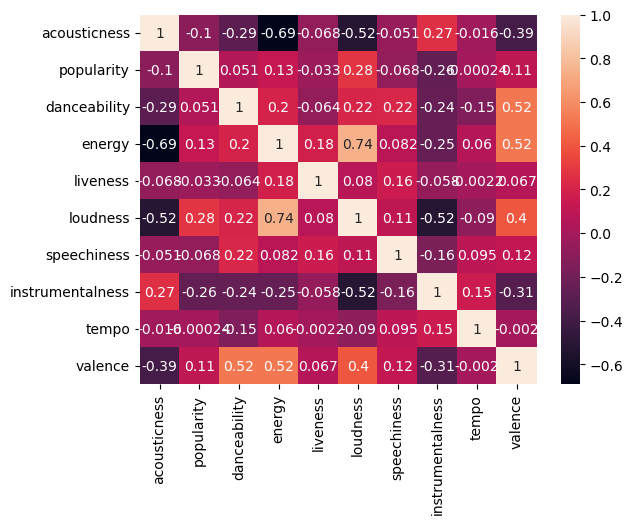

In [36]:
#correlation matrix 
corr_matrix = df_final.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

# Building my target dataframe

### The target dataframe consists of songs from featured playlists created by Spotify

In [16]:
#'https://api.spotify.com/v1/'
r = requests.get(BASE_URL + 'browse/featured-playlists', headers=headers)
results = r.json()

#### Get the playlists' ids

In [19]:
playlists_links = [x["uri"] for x in results['playlists']['items']]

#strip the part spotify:playlist:uri and take only the uri section
uri_playlists = [i.split(':')[2] for i in playlists_links]
#remove playlist located at index 6, it's giving weird errors when trying to extract its tracks 
uri_playlists.pop(6)

'37i9dQZF1DWTvM9hRJYH10'

#### Extract all the songs from these playlists 

In [21]:
#need to extract tracks uris from playlists above 

featured_track_ids = []
for id in uri_playlists:
    #tr_id = uri_playlists[id]
    playlist_tracks = requests.get(BASE_URL + 'playlists/' + id + '/tracks', headers=headers)
    tracks_json = playlist_tracks.json()
    track_ids = [x["track"]["uri"] for x in tracks_json["items"]]
    featured_track_ids.append(track_ids)



#this is a 2D list which needs to be flatten 
flatten_list = []
for i in featured_track_ids:
    for j in i:
        flatten_list.append(j)
        
#strip the part spotify:tracks:uri and take only the uri section
uri_tracks_spotify = [i.split(':')[2] for i in flatten_list]


In [33]:
feature_extract = get_audio_features(uri_tracks_spotify)

In [34]:
df_features_spotify = dictionary_to_df(feature_extract)
df_features_spotify

,track_uri,acousticness,popularity,danceability,energy,liveness,loudness,speechiness,instrumentalness,tempo,valence
0,0VjIjW4GlUZAMYd2vXMi3b,0.00146,90,0.514,0.730,0.0897,-5.934,0.0598,0.000095,171.005,0.334
1,76OGwb5RA9h4FxQPT33ekc,0.10700,89,0.565,0.636,0.4470,-8.198,0.0638,0.000010,170.010,0.525
2,5nujrmhLynf4yMoMtj8AQF,0.00883,83,0.702,0.825,0.0674,-3.787,0.0601,0.000000,102.977,0.915
3,0tgVpDi06FyKpA1z0VMD4v,0.16300,88,0.599,0.448,0.1060,-6.312,0.0232,0.000000,95.050,0.168
4,5HCyWlXZPP0y6Gqq8TgA20,0.03830,85,0.591,0.764,0.1030,-5.484,0.0483,0.000000,169.928,0.478
...,...,...,...,...,...,...,...,...,...,...,...
528,6H5DZBYLOJ8pbmYy6JdTfq,0.44400,46,0.754,0.333,0.1080,-9.791,0.0296,0.016400,108.021,0.157
529,5giA96riscHWo0h3Aq3uPz,0.47400,46,0.678,0.380,0.1080,-11.353,0.3990,0.004160,93.335,0.336
530,0D9OkPTPIn9QkDucglW4DS,0.74300,46,0.564,0.322,0.0962,-11.213,0.0987,0.000000,91.632,0.596
531,6rRCyEuP7uDdX7ste026ky,0.00988,45,0.706,0.688,0.0839,-6.838,0.0698,0.040700,100.016,0.458


# Cleaning and preparing the base and the target datasets

### Base dataset  consists of songs that I already like 

### Target dataset consists of songs from Spotify featured playlists

In [37]:
#remove duplicates if there are any in df_final (which is a dataframe from liked songs and songs from Mood 11 playlist)
#remove duplicates in the featured_playlists from spotify 
df_final.drop_duplicates()
df_features_spotify.drop_duplicates()

,track_uri,acousticness,popularity,danceability,energy,liveness,loudness,speechiness,instrumentalness,tempo,valence
0,0VjIjW4GlUZAMYd2vXMi3b,0.00146,90,0.514,0.730,0.0897,-5.934,0.0598,0.000095,171.005,0.334
1,76OGwb5RA9h4FxQPT33ekc,0.10700,89,0.565,0.636,0.4470,-8.198,0.0638,0.000010,170.010,0.525
2,5nujrmhLynf4yMoMtj8AQF,0.00883,83,0.702,0.825,0.0674,-3.787,0.0601,0.000000,102.977,0.915
3,0tgVpDi06FyKpA1z0VMD4v,0.16300,88,0.599,0.448,0.1060,-6.312,0.0232,0.000000,95.050,0.168
4,5HCyWlXZPP0y6Gqq8TgA20,0.03830,85,0.591,0.764,0.1030,-5.484,0.0483,0.000000,169.928,0.478
...,...,...,...,...,...,...,...,...,...,...,...
528,6H5DZBYLOJ8pbmYy6JdTfq,0.44400,46,0.754,0.333,0.1080,-9.791,0.0296,0.016400,108.021,0.157
529,5giA96riscHWo0h3Aq3uPz,0.47400,46,0.678,0.380,0.1080,-11.353,0.3990,0.004160,93.335,0.336
530,0D9OkPTPIn9QkDucglW4DS,0.74300,46,0.564,0.322,0.0962,-11.213,0.0987,0.000000,91.632,0.596
531,6rRCyEuP7uDdX7ste026ky,0.00988,45,0.706,0.688,0.0839,-6.838,0.0698,0.040700,100.016,0.458


In [38]:
#I will use df_final as my target, so I can find similiar songs in df_features_spotify 
#checking if there is any song that is in both dataframes, 
# I need to remove those so my training set and testing set won't have any songs in common 
cond = df_features_spotify['track_uri'].isin(df_final['track_uri'])
df_features_spotify.drop(df_features_spotify[cond].index, inplace = True)


## Correlation matrix for the target dataset 

### Reasons for feature removal

#### POPULARITY - I removed popularity from the feature set because I like songs both popular and unpopular so it is not something that affects my music taste.  

#### LIVENESS - low correlation with all other features, (highest correlation 0.21 with energy)
#### SPEECHINESS - low correlation with all other features, (highest correlation 0.2 with valence)
#### INSTRUMENTALNESS - low correlation with all other features, (highest correlation 0.12 with popularity)
#### TEMPO - low correlation with all other features, (highest correlation 0.1 with shpeechiness)

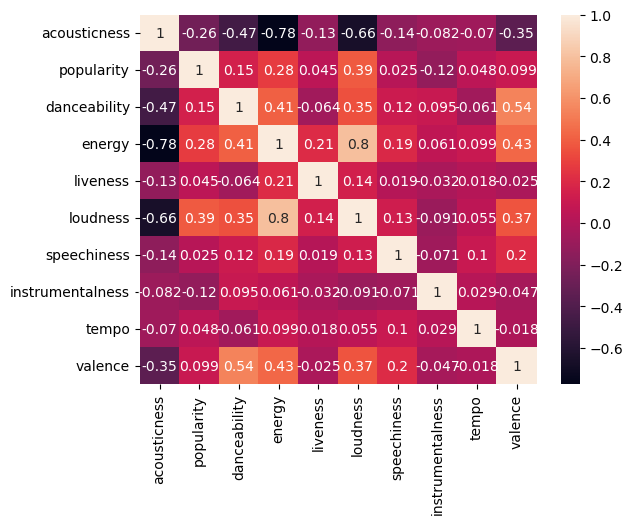

In [39]:
#correlation matrix 
corr_matrix = df_features_spotify.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [97]:
df_featured_cleaned = df_features_spotify.drop(columns=['track_uri','popularity','liveness','speechiness','instrumentalness','tempo'])
df_base_cleaned = df_final.drop(columns=['track_uri','popularity','liveness','speechiness','instrumentalness','tempo'])


# Normalize datasets


In [98]:
df_featured_cleaned=(df_featured_cleaned-df_featured_cleaned.mean())/df_featured_cleaned.std()
df_base_cleaned=(df_base_cleaned-df_base_cleaned.mean())/df_base_cleaned.std()

In [107]:
df_base_cleaned

,acousticness,danceability,energy,loudness,valence
0,-0.778210,0.585456,-0.725351,-0.157038,-0.201395
1,0.291247,-0.027553,0.786529,-0.126853,1.116036
2,-1.036467,1.438338,0.648187,0.034219,1.352602
3,-0.904197,0.718719,0.895226,0.638433,-0.960039
4,0.237298,0.445530,-1.254014,-0.840097,0.895784
...,...,...,...,...,...
95,-0.321231,-0.300742,0.544430,0.869502,-1.070165
96,0.605420,-0.673877,0.376444,-0.535648,0.182006
97,0.031023,-0.707193,0.371503,0.542935,1.111957
98,-0.917525,0.625435,1.196614,1.080795,1.829814


In [105]:
df_featured_cleaned

,acousticness,danceability,energy,loudness,valence
0,-1.154212,-0.731187,0.724335,0.589676,-0.549894
1,-0.833025,-0.385210,0.312032,-0.062885,0.306944
2,-1.131783,0.544179,1.141024,1.208513,2.056508
3,-0.662601,-0.154559,-0.512573,0.480723,-1.294580
4,-1.042098,-0.208829,0.873466,0.719381,0.096099
...,...,...,...,...,...
528,0.192559,0.896940,-1.016986,-0.522040,-1.343927
529,0.283857,0.381367,-0.810835,-0.972261,-0.540922
530,1.102498,-0.391994,-1.065234,-0.931908,0.625454
531,-1.128587,0.571315,0.540115,0.329113,0.006378


# Cosine Similiarity between the datasets 

In [100]:
cosine_array = []
indexes = []
for i in range(len(df_base_cleaned)):
    loc = 0
    X = np.array(df_base_cleaned.iloc[i])
    for j in range(len(df_featured_cleaned)):
        Y = np.array(df_featured_cleaned.iloc[j])
        cosine = np.dot(X,Y)/(norm(X)*norm(Y))
        cosine_array.append(cosine)
        
        # appending only the location row where cosine similiarity is larger than 0.993 
        #by having that location row we are able to extract track_uri from df_features_spotify
        if(cosine > 0.993):
            indexes.append(loc)
        loc+=1        

In [101]:
#removing duplicates 
new_indexes = list(set(indexes))
#extracting the recommended track_uris from df_featured_spotify
recommended_tracks = []

for i in new_indexes:
    uri = df_features_spotify.iloc[i][0]
    recommended_tracks.append(uri)

# Creating the playlist into my Spotify account using Jupyter Notebook

In [102]:
response = sp.user_playlist_create(user=user_id,name="Cosine Similarity", public =True,description = "Creating playlist using python ")

In [103]:
new_playlist_id = response['uri'].split(':')[2]

In [104]:
sp.user_playlist_add_tracks(user=CLIENT_ID, 
                                playlist_id= new_playlist_id, 
                                tracks=recommended_tracks,)

{'snapshot_id': 'MywwN2IwYzQ1MTg4YjM5YmQ3NTA3ZWFjOWY0NThjZTg5NGVhOTZmNjQ0'}